In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics
import seaborn as sns
from scipy.spatial import distance
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.patches import Ellipse
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import sys
sys.path.insert(0, '../../Code/')

#payment_inc_ratio  = razon entre el pago del prestamo y los ingreso 	
#dti                = razon entre el pago de las deudas (Excluyendo el prestamo)  debt-to-income
#revol_bal          = credito renovable
#revol_util         = porcentaje del credito que se utiliza

In [13]:
df = pd.read_csv("../../datasets/loan200.csv")

In [ ]:
df["outcome"].unique()

In [ ]:
norder = ['payment_inc_ratio', 'dti', 'outcome']
df = df[norder]
df[df["outcome"]!="target"]

In [16]:
fields_predictors = ["payment_inc_ratio", "dti"] 
field_outcome = 'outcome'
nloan = df.loc[0:0, fields_predictors]
X   =   df.loc[1:, fields_predictors] 
y   =   df.loc[1:, field_outcome]


In [ ]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
knn.predict(nloan)

In [ ]:
print(knn.predict_proba(nloan))

In [ ]:
nbrs = knn.kneighbors(nloan)
maxDistance = np.max(nbrs[0][0])

fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=df, alpha=0.3, s=100, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', 
                data=pd.concat([df.loc[0:0, :], df.loc[nbrs[1][0] + 1,:]]), 
                ax=ax, legend=False, s=100)
ellipse = Ellipse(xy=nloan.values[0], 
                  width=2 * maxDistance, height=2 * maxDistance,
                  edgecolor='black', fc='None', lw=1)
ax.add_patch(ellipse)
ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()

## Seleccion de K

#### Usamos el dataset completo

In [20]:
df = pd.read_csv("../../datasets/loan_data.csv.gz")
df = df.drop(columns=['Unnamed: 0', 'status'])
X   =   df.loc[:, fields_predictors] 
y   =   df.loc[:, field_outcome]

In [ ]:
conteo_clases = df.loc[:, 'outcome'].value_counts()
conteo_clases.plot(kind='bar', color=['blue', 'green'])

#### Veamos que K es el que mejor funciona

In [ ]:
acus = []
ks = list(range(23, 0, -2))
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    acus.append(knn.score(X, y))

plt.plot(ks, acus, 'b-')
plt.xlabel('Valor de k')
plt.ylabel('score (Exactitud)')
plt.gca().invert_xaxis()


#### Parece que lo mejor es que K, sea 1, tenemos incluso un rendimiento perfecto de 1. ¿Tenemos el clasificador perfecto?

### Evaluación con una grupo de reserva

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)
acus = []
ks = list(range(80, 0, -2))
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    acus.append(knn.score(X_test, y_test))

plt.plot(ks, acus, 'b-')
plt.xlabel('Valor de k')
plt.ylabel('score (Exactitud)')
plt.gca().invert_xaxis()


### Ahora el rendimiento es inverso, tiende a ser mejor cuanto mas grande es el K

### ¿Si quiero utilizar todos los datos y hacer validación cruzada? ¿Sucedio que tengo mucha mala suerte con la seleccion de las muestras de validación o testeo?

In [ ]:
#Atencion demora 3 minutos la ejecución
from sklearn.model_selection import cross_val_score
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)
acus = []

ks = list(range(40, 0, -2))
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    #knn.fit(X_train, y_train)
    acus.append(cross_val_score(knn, X, y, cv=3).mean())

plt.xlabel('Valor de k')
plt.ylabel('score (Exactitud)')
plt.plot(ks, acus, 'b-')
plt.gca().invert_xaxis()
print("Maximo score:", max(acus))


Parece que no, el patrón es el mismo

### ¿Con distancia manhattan obtendre mejores resultados?

In [ ]:
#Atencion demora 3 minutos la ejecución
from sklearn.model_selection import cross_val_score
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)
acus = []

ks = list(range(80, 0, -2))
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k, metric="manhattan")
    #knn.fit(X_train, y_train)
    acus.append(cross_val_score(knn, X, y, cv=3).mean())

plt.xlabel('Valor de k')
plt.ylabel('score (Exactitud)')
plt.plot(ks, acus, 'b-')
plt.gca().invert_xaxis()
print("Maximo score:", max(acus))

### Con manhattan tiene una mejora despreciable, en cualquier caso estamos hablando de un clasificador débil, y target bien balanceado. Como vimos los datos parecen ser muy ruidosos y los campos en este caso puntual parecen no tener gran valor predictor. Sumemos algunos campos mas.

## Estandarización (Z-score)

#### Antes de ajustar un modelo con mas campos observermos el problema de la escala de los datos

In [26]:
fields_predictors.append("revol_bal")
fields_predictors.append("revol_util")

In [27]:
nloan = df.loc[0:0, fields_predictors]
X   =   df.loc[1:, fields_predictors] 
y   =   df.loc[1:, field_outcome]

### revol_bal tiene un orden de magnitud muy superior y tenderá a dominar las distancias 

In [ ]:
X

### Obtengo los 5 vecinos mas cercanos. El valor revol_bal estan muy cerca pero el resto de las variables estan por todo el espectro y no juegan ningún papel en la determinación de "vecino".

In [ ]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X, y)

nbrs = model.kneighbors(nloan)
print(X.iloc[nbrs[1][0], :])

#### Escalo todas las variables (Observar grupos de datos para fit y transform)

In [30]:
nloan = df.loc[0:0, fields_predictors]
X = df.loc[1:, fields_predictors]
y = df.loc[1:, field_outcome]

scaler = StandardScaler()
scaler.fit(X) #scaler.fit(X*1.0) para hacer flotante revol_bal
X_std = scaler.transform(X)
nloan_std = scaler.transform(nloan)

#### Ahora todas estan mas cerca

In [ ]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_std, y)
nbrs = model.kneighbors(nloan_std)
print(X.iloc[nbrs[1][0], :])


### Elección de K

#### Volvamos a la eleccion de K con datos estandarizados e incorporando las nuevas columnas. Vemos la evolucion de las curvas de validación

In [ ]:
#columnas actuales: [payment_inc_ratio,dti,revol_bal,revol_util]
#Setear vecinos en un valor inferior a 200, demora mucho para una clase en vivo
from sklearn.model_selection import validation_curve
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.3)

ss = StandardScaler()
ss.fit(X_train)
X_train_scl = ss.transform(X_train)
X_test_scl = ss.transform(X_test)

model = KNeighborsClassifier(metric="manhattan")
n_neighbors = np.arange(1,50,2)
# Calcular las curvas de validación
train_scores, valid_scores = validation_curve(model, X_train_scl, y_train, 
                                              param_name="n_neighbors", 
                                              param_range=n_neighbors[::-1], 
                                              scoring="accuracy", 
                                              cv=3)
plt.plot(n_neighbors[::-1], np.median(train_scores, 1), color='blue', label='training score')
plt.plot(n_neighbors[::-1], np.median(valid_scores, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlim(max(n_neighbors[::-1]), min(n_neighbors[::-1]))
plt.xlabel('Cantidad de vecinos')
plt.ylabel('score')
#Atencion, es el maximo de todos los scores, no es representativo del score real
print("Max score", valid_scores.max())

In [ ]:
np.median(valid_scores, 1).max()

-----------------------------

#### El clasificador sigue siendo débil. Los datos son muy ruidosos para este algoritmo que no tiene la capacidad de entender si una caracteristica es mas importante que la otra, intentemos mejorar seleccionando solo las mejores variables.

In [47]:
df = pd.read_csv("../../datasets/loan_data.csv.gz")
df['outcome'] = pd.Categorical(df['outcome'], 
                                categories=['paid off', 'default'], 
                                ordered=True)

for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype('category')
#df.loc[:, df.select_dtypes(include=['object']).columns] = df[df.select_dtypes(include=['object']).columns].astype('category')
num_pred = df.select_dtypes(include=['float64', 'int64']).columns
cat_pred = df.select_dtypes(include=['category']).drop(columns='outcome').columns
outcome = "outcome"

#### KNN es naturalmente sensible a la cantidad de dimensiones. Busquemos solo los mejores features 

In [48]:
dfs = df.sample(frac=0.1, random_state=0)
# solo los numericos
X = dfs[num_pred]
y = dfs[outcome]


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)
ss = StandardScaler()
ss.fit(X_train)
X_train_scl_df = pd.DataFrame(ss.transform(X_train), columns=X_train.columns) 
X_test_scl_df = pd.DataFrame(ss.transform(X_test), columns=X_test.columns) 

### Esta técnica para seleccionar las variables la veremos mas adelante, por ahora la selección es por intuición o inspección visual

In [ ]:
#No ejecutar, la uso el docente para seleccionar las variables, demora 1 dia
from FeatureSelection import SimpleExhaustiveSearch
model = KNeighborsClassifier(n_neighbors=19, metric="manhattan")
exs = SimpleExhaustiveSearch(estimator=model, scoring="accuracy", cv=3, verbose=True)
exs.fit(X_train_scl_df, y_train)
print(exs.best_subset_, exs.best_score_)
X.columns[exs.best_subset_]
#X.columns.drop(X.columns[exs.best_subset_])
#exs.transform(X)

¿Las mas importantes son dti, payment_inc_ratio y grade? Es posible, se llego a esa conclusión en parte via busqueda exaustiva y otras pruebas. La busqueda exhaustiva fue con una muy pequeña muestra dado que caso de intentar con todos los datos demoraria varios dias. Esto fue una solución de compromiso dado la falta de tiempo para ejecutar completamente la prueba.

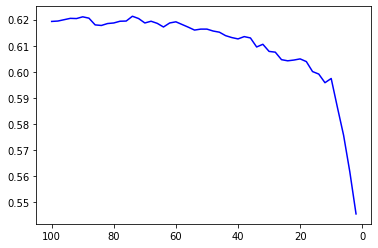

In [60]:
X = df.loc[:,["dti","payment_inc_ratio", "grade"]]
y = df[outcome]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)
ss = StandardScaler()
ss.fit(X_train) #SimpleInputer
# Conservo nombres de columnas, SBS pide dataframe
X_train_scl_df = pd.DataFrame(ss.transform(X_train), columns=X_train.columns) 
X_test_scl_df = pd.DataFrame(ss.transform(X_test), columns=X_test.columns) 
acus = []
ks = list(range(100, 0, -2))
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scl_df, y_train)
    acus.append(knn.score(X_test_scl_df, y_test))

plt.plot(ks, acus, 'b-')
plt.gca().invert_xaxis()

In [61]:
print(max(acus))

0.621260016172903


Los resultados mejoran sensiblemente, estamos por arriba el 0.6

Probemos con otras columnas que se relevaron importantes en otras pruebas y no son numéricas

In [62]:
df.columns

Index(['Unnamed: 0', 'status', 'loan_amnt', 'term', 'annual_inc', 'dti',
       'payment_inc_ratio', 'revol_bal', 'revol_util', 'purpose',
       'home_ownership', 'delinq_2yrs_zero', 'pub_rec_zero', 'open_acc',
       'grade', 'outcome', 'emp_length', 'purpose_', 'home_', 'emp_len_',
       'borrower_score'],
      dtype='object')

In [67]:
#X = df[["payment_inc_ratio","grade", "purpose"]] #dti
selected_num_cols = ["payment_inc_ratio","grade", "dti"]
selected_cat_cols = ["term", "home_ownership"]
X  = df[selected_num_cols+selected_cat_cols] #grade	term_60 months	home_ownership
y = df["outcome"]


In [69]:
scaler = StandardScaler()
tdf = scaler.fit_transform(X[selected_num_cols])
tdf = pd.get_dummies(X, columns=selected_cat_cols)
X = tdf
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.7)

0.6220686613247078


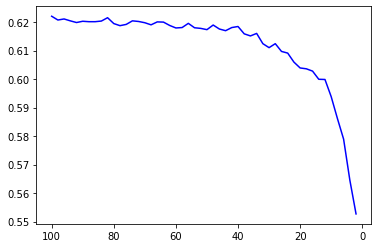

In [70]:
acus = []
ks = list(range(100, 0, -2))
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k, metric="manhattan")
    knn.fit(X_train, y_train)
    acus.append(knn.score(X_test, y_test))

plt.plot(ks, acus, 'b-')
plt.gca().invert_xaxis()
print(max(acus))

#### Mejora muy sensiblemente el rendimiento aunque aún no esta muy lejos del azar ¿Debería descartar totalmente el uso de KNN con este dataset?.

# KNN como motor de características

In [71]:
df = pd.read_csv("../../datasets/loan_data.csv.gz")
df['outcome'] = pd.Categorical(df['outcome'], 
                                categories=['paid off', 'default'], 
                                ordered=True)

predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
outcome = 'outcome'


In [72]:
"""
df.loc[:,['status', 'loan_amnt', 'term', 'annual_inc', 'dti',
       'payment_inc_ratio', 'revol_bal', 'revol_util', 'purpose',
       'home_ownership', 'delinq_2yrs_zero', 'pub_rec_zero', 'open_acc',
       'grade', 'outcome', 'emp_length']].to_csv("../../datasets/raw_loan_data.csv.gz", compression='gzip')
       #"status"
"""

'\ndf.loc[:,[\'status\', \'loan_amnt\', \'term\', \'annual_inc\', \'dti\',\n       \'payment_inc_ratio\', \'revol_bal\', \'revol_util\', \'purpose\',\n       \'home_ownership\', \'delinq_2yrs_zero\', \'pub_rec_zero\', \'open_acc\',\n       \'grade\', \'outcome\', \'emp_length\']].to_csv("../../datasets/raw_loan_data.csv.gz", compression=\'gzip\')\n       #"status"\n'

In [73]:
col_num = ["dti", "revol_bal", "revol_util", "open_acc"]
df.loc[:, col_num] = StandardScaler().fit_transform(df[col_num])


In [74]:
X = df[predictors]
y = df[outcome]

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
#plt.scatter(range(len(X)), [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:,0]], 
#            alpha=0.1, marker='.')
#knn.predict_proba(X)[:, 0]

df.loc[:,'borrower_score_'] = knn.predict_proba(X)[:, 1]


In [75]:
df.loc[:, ['borrower_score_']]

,borrower_score_
0,0.65
1,0.65
2,0.50
3,0.45
4,0.45
...,...
45337,0.65
45338,0.65
45339,0.55
45340,0.40


### Verifico la colinealidad entre variables


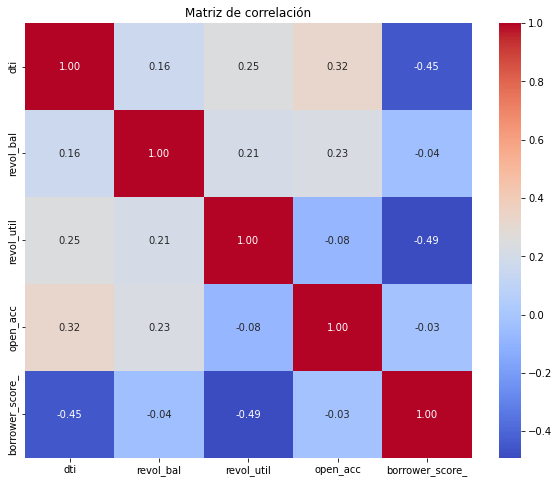

In [76]:
correlation_matrix = df.loc[:,["dti", "revol_bal", "revol_util", "open_acc", 'borrower_score_']].corr()

# Crea el heatmap utilizando seaborn
plt.figure(figsize=(10, 8))  # Ajusta el tamaño del plot si es necesario
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación')
plt.show()

#### Ejemplo de ruido

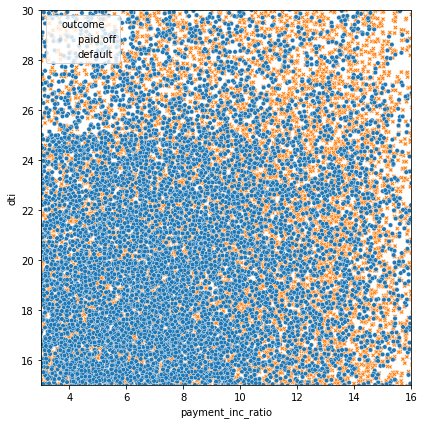

In [77]:
df = pd.read_csv("../../datasets/loan_data.csv.gz")
df['outcome'] = pd.Categorical(df['outcome'], 
                                categories=['paid off', 'default'], 
                                ordered=True)


fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', data=df, alpha=0.3, s=20, ax=ax)
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome', 
                hue='outcome', 
                data=df, 
                ax=ax, legend=False, s=20)

ax.set_xlim(3, 16)
ax.set_ylim(15, 30)

plt.tight_layout()
plt.show()